In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image

2024-04-08 17:40:27.056981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 17:40:27.057115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 17:40:27.189899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
breast_img = glob.glob('/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/*/*.png', recursive = True)
for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13591_idx5_x2951_y651_class0.png
/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13666_idx5_x1151_y251_class0.png
/kaggle/input/idc-data-2-sample/IDC_Data_2_Sample/Original/0/13024_idx5_x551_y601_class0.png


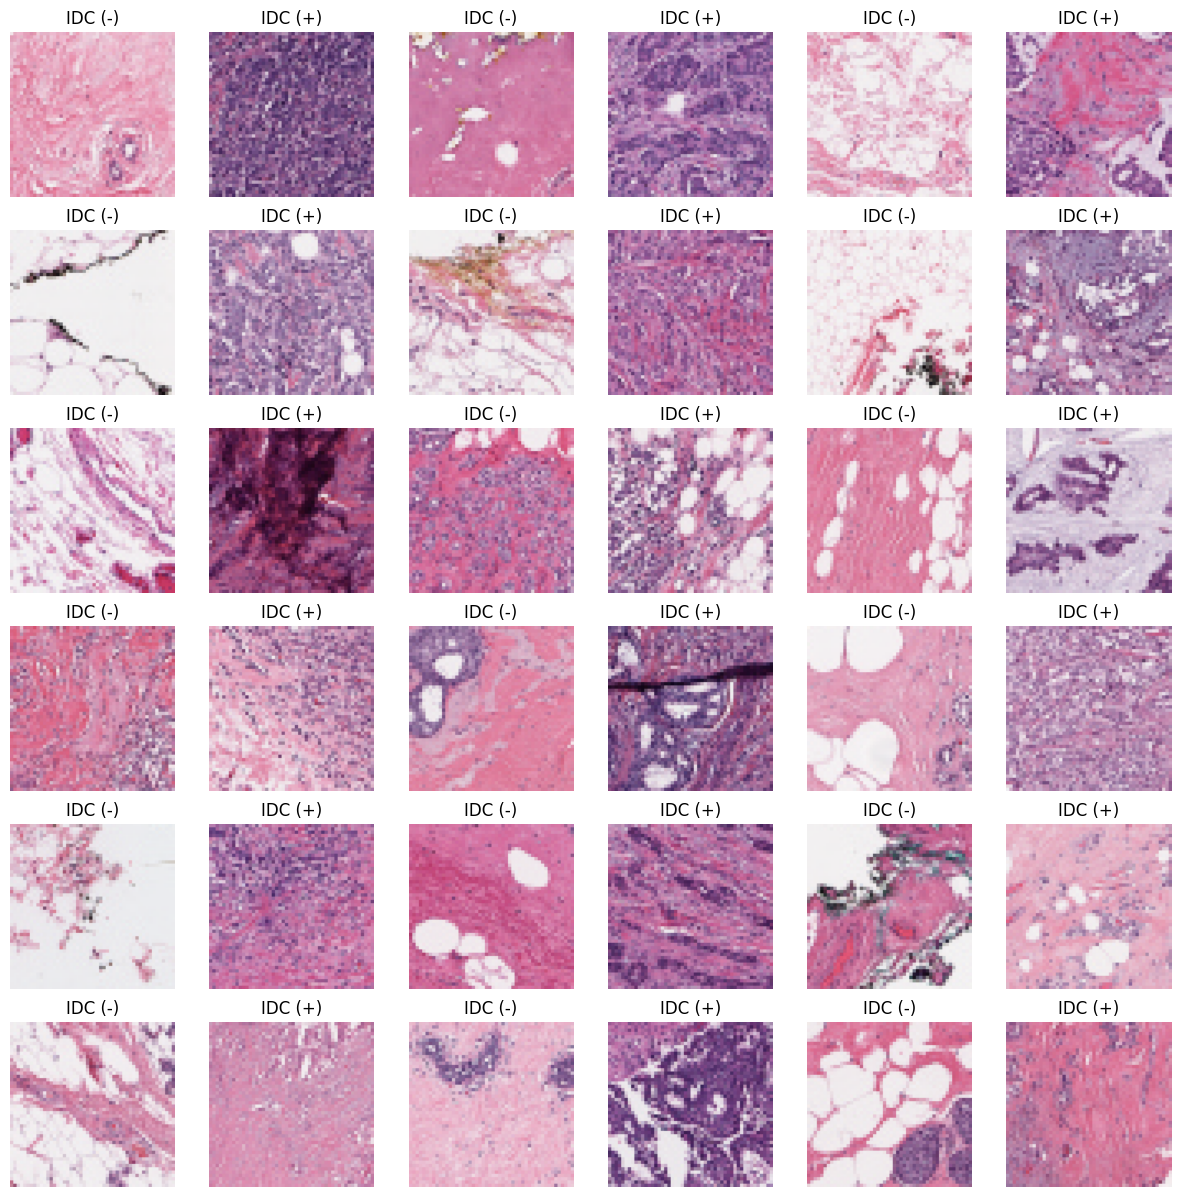

In [3]:
N_IDC = []
P_IDC = []

for img in breast_img:
    #if img[-5] == '0' :
    if 'class0' in img:
        N_IDC.append(img)
    elif 'class1' in img:
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('IDC (-)')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [4]:
print(len(N_IDC))
print(len(P_IDC))

10000
10000


In [5]:
#N_IDC=N_IDC[:50000]
#P_IDC = P_IDC[:50000]
#print(len(NewN_IDC))
#print(len(P_IDC))

In [6]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 26.8 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=16b6dd2e4969646bb6146036bbf9603749eee069dbae0fcdd8429d83f1eeb798
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [7]:
import numpy as np
import skfuzzy as fuzz

def extract_membership_images(image):
    # Convert the image to grayscale
    image_gray = np.mean(image, axis=2)

    # Define membership functions
    x = np.arange(0, 256, 1)
    foreground_membership = fuzz.trimf(x, [0, 100, 255])  # Example membership function for foreground
    background_membership = fuzz.trimf(x, [0, 50, 255])   # Example membership function for background

    # Fuzzification
    foreground_degree = fuzz.interp_membership(x, foreground_membership, image_gray)
    background_degree = fuzz.interp_membership(x, background_membership, image_gray)

    # Thresholding
    threshold = 0.5  # Adjust the threshold as needed
    foreground_mask = foreground_degree >= threshold
    background_mask = background_degree >= threshold

    # Create membership and non-membership images
    membership_image = np.zeros_like(image_gray)
    membership_image[foreground_mask] = 255  # Set foreground pixels to 255
    non_membership_image = np.zeros_like(image_gray)
    non_membership_image[background_mask] = 255  # Set background pixels to 255

    membership_image = np.expand_dims(membership_image, axis=-1)
    membership_image = np.repeat(membership_image, 3, axis=-1)
    
    non_membership_image = np.expand_dims(non_membership_image, axis=-1)
    non_membership_image = np.repeat(non_membership_image, 3, axis=-1)
    
    #return membership_image, non_membership_image
    return non_membership_image

# Example usage:
# membership_image, non_membership_image = extract_membership_images(image)
# plt.imshow(membership_image, cmap='gray')
# plt.title('Membership Image')
# plt.axis('off')
# plt.show()


In [8]:
#membership_non_img_arr = []
#membership_can_img_arr = []
#non_membership_non_img_arr = []
#non_membership_can_img_arr = []

non_img_arr = []
can_img_arr = []


for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img = extract_membership_images(n_img)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img = extract_membership_images(c_img)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [9]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr))

10000
10000
20000


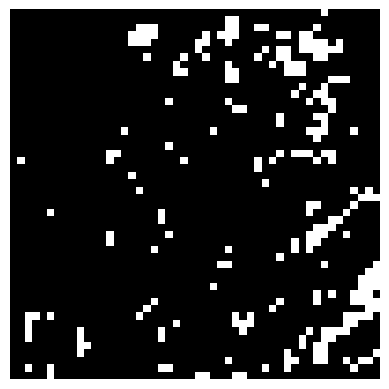

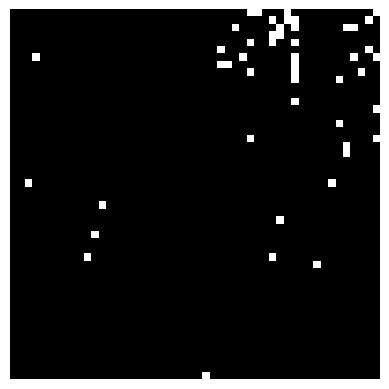

In [10]:
img = non_img_arr[0][0]
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


img = can_img_arr[0][0]
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [11]:
X = []
y = []

#breasextendt_img_arr = np.concatenate((non_img_arr[:12389], can_img_arr[:12389]))
#breast_img_arr = np.concatenate((non_img_arr, can_img_arr))
breast_img_arr = non_img_arr+ can_img_arr
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)


In [12]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

Total number of images: 20000
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

#from tensorflow.keras.utils import to_categorical
#Y_train = to_categorical(Y_train, num_classes = 2)
#Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)


In [14]:
def describeData(y):
    print('Number of IDC(-) Images: {}'.format(np.sum(y==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(y==1)))
describeData(Y_test)

Number of IDC(-) Images: 2035
Number of IDC(+) Images: 1965


In [15]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Model

# VGG16 MODEL

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16


vgg_model=VGG16(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
  5/250 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5657 - loss: 6.7643  

I0000 00:00:1712598168.912135     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.7226 - loss: 0.9276 - val_accuracy: 0.7513 - val_loss: 0.5136
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7528 - loss: 0.5228 - val_accuracy: 0.7570 - val_loss: 0.5097
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7655 - loss: 0.4947 - val_accuracy: 0.7598 - val_loss: 0.5013
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7665 - loss: 0.4905 - val_accuracy: 0.7600 - val_loss: 0.4998
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7778 - loss: 0.4740 - val_accuracy: 0.7657 - val_loss: 0.5110
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7755 - loss: 0.4761 - val_accuracy: 0.7563 - val_loss: 0.5010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7900 - loss: 0.4514 - val_accuracy: 0.7605 - val_loss: 0.5257
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8014 - loss: 0.4276 - val_accuracy: 0.74

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


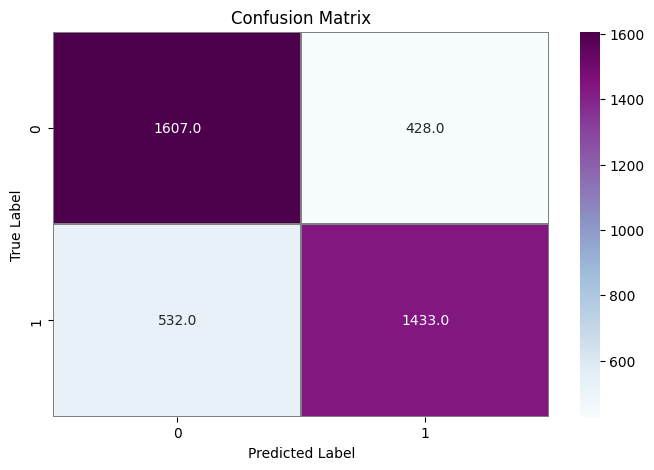

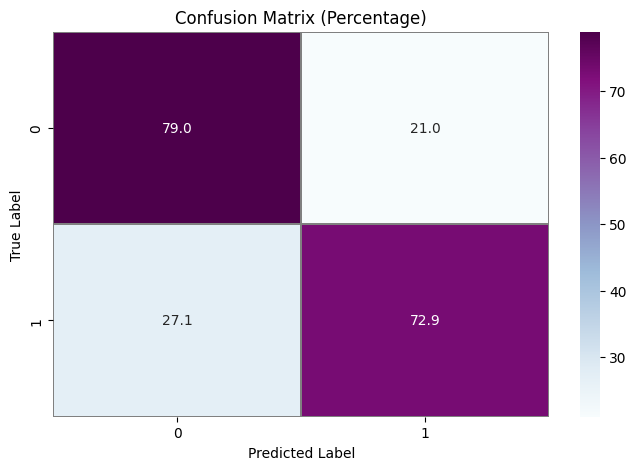

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7687 - loss: 0.4876
[0.4997236430644989, 0.7599999904632568]

              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2035
           1       0.77      0.73      0.75      1965

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))


# VGG19 MODEL

In [19]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg_model=VGG19(input_shape=(50,50,3),include_top=False)
x=Flatten()(vgg_model.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg_model.input,outputs=prediction)
#model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [20]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.6879 - loss: 1.2246 - val_accuracy: 0.7527 - val_loss: 0.5091
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7592 - loss: 0.5089 - val_accuracy: 0.7548 - val_loss: 0.5030
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7657 - loss: 0.4997 - val_accuracy: 0.7513 - val_loss: 0.5206
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7614 - loss: 0.5034 - val_accuracy: 0.7615 - val_loss: 0.5106
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7723 - loss: 0.4825 - val_accuracy: 0.7600 - val_loss: 0.5011
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7777 - loss: 0.4704 - val_accuracy: 0.7628 - val_loss: 0.5016
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - accuracy: 0.7817 - loss: 0.4677 - val_accuracy: 0.7610 - val_loss: 0.5120
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.7875 - loss: 0.4546 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


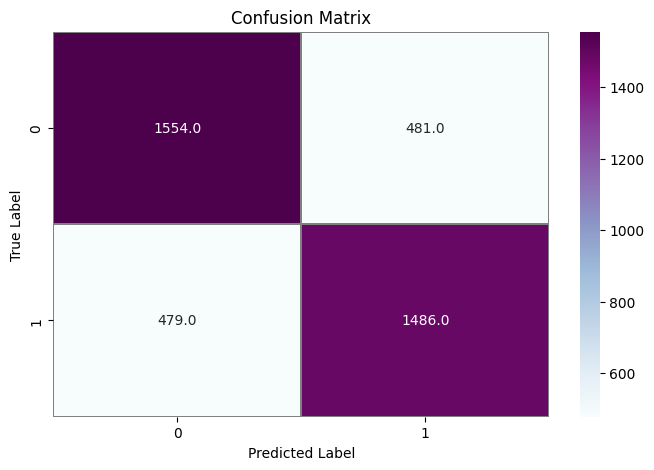

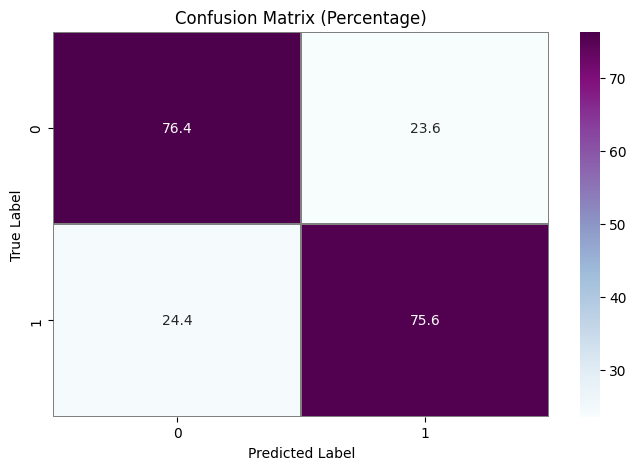

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7689 - loss: 0.4938
[0.5006818175315857, 0.7599999904632568]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2035
           1       0.76      0.76      0.76      1965

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))

# ResNET_50

In [22]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model (without the top classification layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet50 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)
#model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 80ms/step - accuracy: 0.7024 - loss: 0.7591 - val_accuracy: 0.7350 - val_loss: 1.1272
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7845 - loss: 0.6372 - val_accuracy: 0.7320 - val_loss: 0.5394
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8678 - loss: 0.3455 - val_accuracy: 0.7458 - val_loss: 0.6105
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9457 - loss: 0.1715 - val_accuracy: 0.7430 - val_loss: 0.7078
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9757 - loss: 0.0831 - val_accuracy: 0.7190 - val_loss: 0.7795
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9897 - loss: 0.0448 - val_accuracy: 0.7303 - val_loss: 0.8498
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9877 - loss: 0.0445 - val_accuracy: 0.7347 - val_loss: 0.9777
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9788 - loss: 0.0681 - 

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


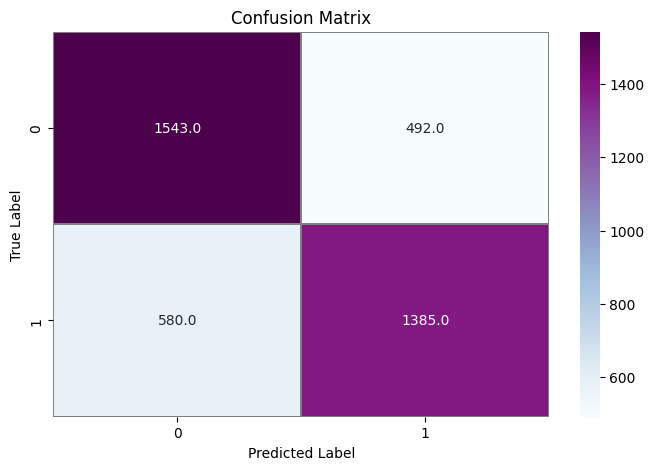

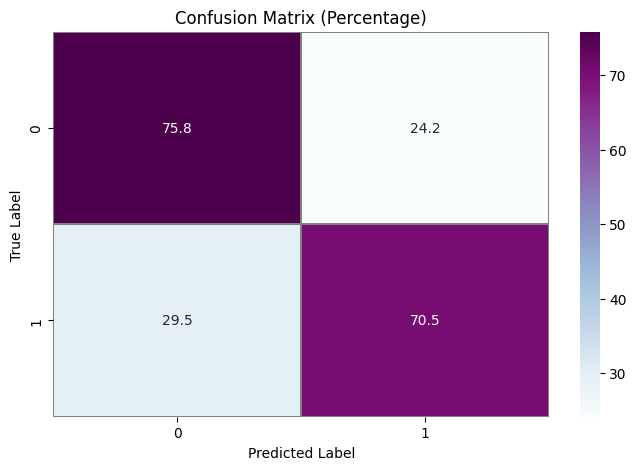

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7353 - loss: 0.5304
[0.5395457148551941, 0.7319999933242798]

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      2035
           1       0.74      0.70      0.72      1965

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))

# ResNet 150

In [25]:
from tensorflow.keras.applications import ResNet152


# Load the pre-trained ResNet152 model (without the top classification layer)
resnet_model = ResNet152(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the ResNet152 base model
x = Flatten()(resnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=resnet_model.input, outputs=prediction)

#model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [26]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 200s 196ms/step - accuracy: 0.6936 - loss: 0.8107 - val_accuracy: 0.7285 - val_loss: 2.4558
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.8055 - loss: 0.4568 - val_accuracy: 0.7520 - val_loss: 0.7505
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.8529 - loss: 0.3781 - val_accuracy: 0.7088 - val_loss: 0.8495
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.8704 - loss: 0.3273 - val_accuracy: 0.7138 - val_loss: 0.6913
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9531 - loss: 0.1359 - val_accuracy: 0.7380 - val_loss: 0.8047
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9831 - loss: 0.0593 - val_accuracy: 0.7393 - val_loss: 0.9644
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9921 - loss: 0.0321 - val_accuracy: 0.7350 - val_loss: 1.0642
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.9923 - loss: 

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step


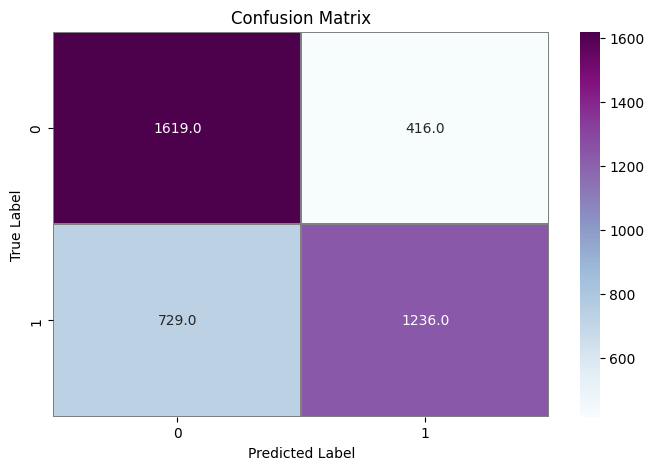

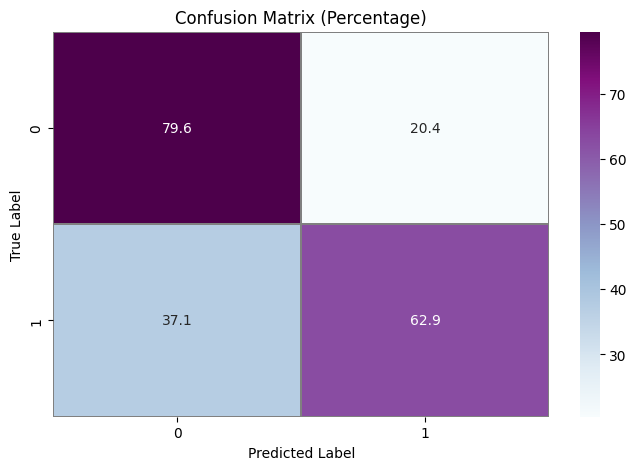

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7194 - loss: 0.6601
[0.6929524540901184, 0.7137500047683716]

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      2035
           1       0.75      0.63      0.68      1965

    accuracy                           0.71      4000
   macro avg       0.72      0.71      0.71      4000
weighted avg       0.72      0.71      0.71      4000



In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))



# DenseNet121

In [28]:
from tensorflow.keras.applications import DenseNet121

# Load the pre-trained DenseNet121 model (without the top classification layer)
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the DenseNet121 base model
x = Flatten()(densenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=densenet_model.input, outputs=prediction)
#model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [29]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 159s 146ms/step - accuracy: 0.6948 - loss: 0.6623 - val_accuracy: 0.7355 - val_loss: 0.5470
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7748 - loss: 0.4837 - val_accuracy: 0.7610 - val_loss: 0.5134
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8130 - loss: 0.4251 - val_accuracy: 0.7440 - val_loss: 0.5447
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8518 - loss: 0.3510 - val_accuracy: 0.7322 - val_loss: 0.6187
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.8938 - loss: 0.2722 - val_accuracy: 0.7240 - val_loss: 0.6815
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9273 - loss: 0.1957 - val_accuracy: 0.7297 - val_loss: 0.8195
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9391 - loss: 0.1684 - val_accuracy: 0.7375 - val_loss: 0.8940
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9592 - loss: 0.1170 

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


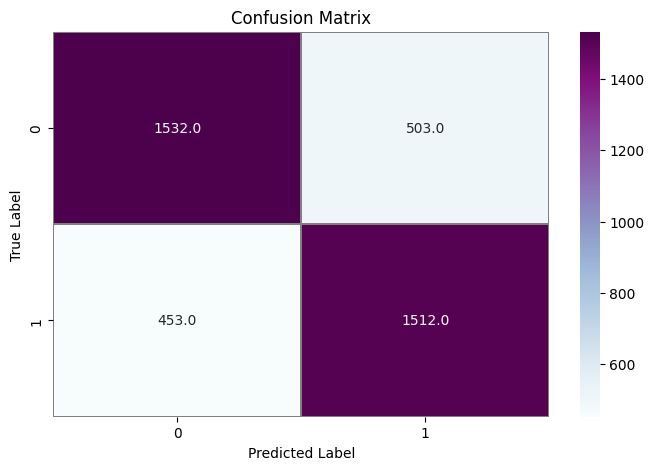

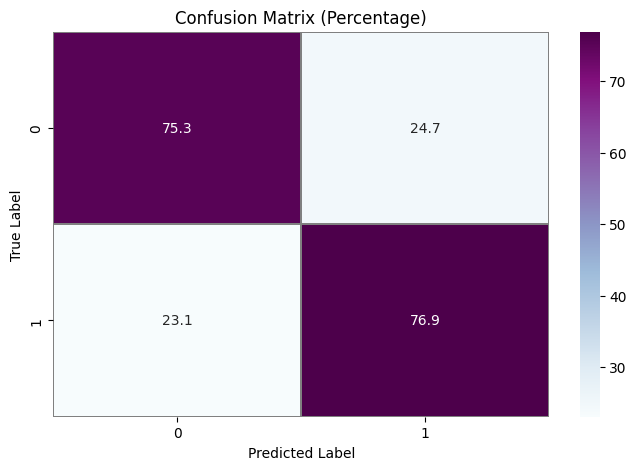

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7738 - loss: 0.5065
[0.5133681297302246, 0.7609999775886536]

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2035
           1       0.75      0.77      0.76      1965

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))



# EfficientNetB0

In [31]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model (without the top classification layer)
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the EfficientNetB0 base model
x = Flatten()(efficientnet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=efficientnet_model.input, outputs=prediction)
#model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 80ms/step - accuracy: 0.6676 - loss: 0.6834 - val_accuracy: 0.6505 - val_loss: 0.7134
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7783 - loss: 0.4882 - val_accuracy: 0.6683 - val_loss: 0.6569
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8118 - loss: 0.4243 - val_accuracy: 0.7095 - val_loss: 0.6084
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.8421 - loss: 0.3640 - val_accuracy: 0.7322 - val_loss: 0.5959
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8705 - loss: 0.3080 - val_accuracy: 0.7305 - val_loss: 0.6231
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8998 - loss: 0.2662 - val_accuracy: 0.7230 - val_loss: 0.6397
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9206 - loss: 0.2212 - val_accuracy: 0.7377 - val_loss: 0.6517
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9347 - loss: 0.1869 - val_ac

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


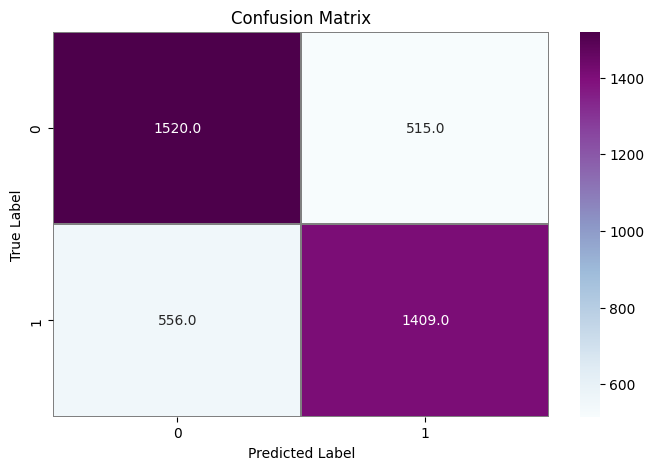

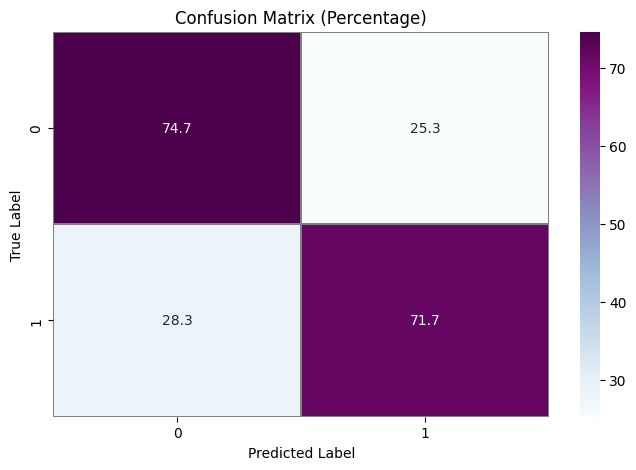

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7319 - loss: 0.5958
[0.5958790183067322, 0.7322499752044678]

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2035
           1       0.73      0.72      0.72      1965

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))


# MobileNetV2

In [34]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model (without the top classification layer)
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Add a Flatten layer to the MobileNetV2 base model
x = Flatten()(mobilenet_model.output)

# Add a Dense layer for binary classification
prediction = Dense(2, activation='softmax')(x)

# Create a new model by specifying the input and output layers
model = Model(inputs=mobilenet_model.input, outputs=prediction)
#model.summary()

/tmp/ipykernel_34/1739306031.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(50, 50, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [35]:
model.compile(Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 50, batch_size = 64, callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 49ms/step - accuracy: 0.6751 - loss: 0.7533 - val_accuracy: 0.6030 - val_loss: 1.0120
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7545 - loss: 0.5160 - val_accuracy: 0.7017 - val_loss: 0.6647
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.7817 - loss: 0.4738 - val_accuracy: 0.6992 - val_loss: 0.7318
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8150 - loss: 0.4182 - val_accuracy: 0.7075 - val_loss: 0.6934
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8204 - loss: 0.3971 - val_accuracy: 0.6940 - val_loss: 0.7170
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8384 - loss: 0.3665 - val_accuracy: 0.7327 - val_loss: 0.6311
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8531 - loss: 0.3371 - val_accuracy: 0.7237 - val_loss: 0.6142
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8759 - loss: 0.2963 - val_acc

125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


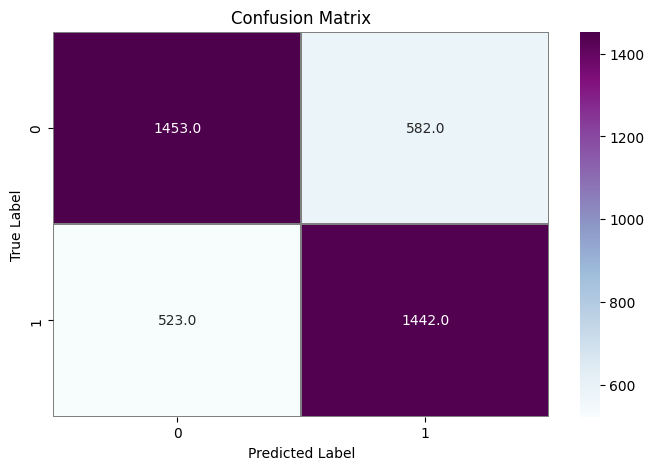

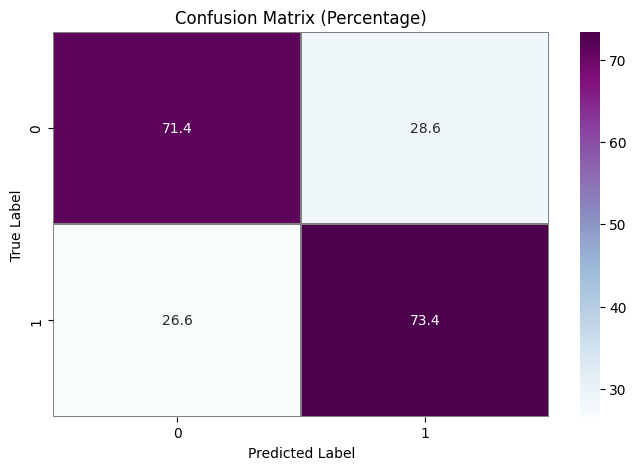

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7305 - loss: 0.6069
[0.613126814365387, 0.7237499952316284]

              precision    recall  f1-score   support

           0       0.74      0.71      0.72      2035
           1       0.71      0.73      0.72      1965

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = Y_test 
#accuracy=accuracy_score(y_true=Y_true, y_pred=Y_pred)
#print(accuracy)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# calculate the percentage
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

print(model.evaluate(X_test,Y_test))
print()
# Classification report
print(classification_report(Y_true, Y_pred_classes))
